In [1]:
import anndata
import umap
import xgboost
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import pickle
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from IPython.display import display, Image, HTML
import mlflow
import re
regex = re.compile(r"perturbation_experiment_([^_]+)_level")

# base definition and original adata:
if not "adata" in locals():
    levels = ["0", "0.5", "1.0"]
    data_dir = "/data/gene_perturbation_colon_epithelial_scGPT_with_binning_1"
    file_pattern = data_dir + "/perturbation_experiment_{gene}_level_{level}"
    base_fname = file_pattern.format(gene = "JUND", level = "1.0")
    base_embeddings = np.load(f"{base_fname}.embeddings.npy")
    adata = anndata.read_h5ad(f"{base_fname}.h5ad")
    base_df = adata.obs[["tissue", "cell_type", 'sex', 'development_stage',"disease"]].copy()
data_dir = "/data/colon_epithelial_cellxgene_perturbation_4"
file_pattern = data_dir + "/perturbations/perturbation_experiment_{gene}_level_{level}"
genes = set([regex.search(f.name).group(1) for f in list(Path(data_dir+"/perturbations").glob("*.npz"))])
model_filename = "cgboost_on_emebeddings_with_binning_predict_disease_2024-05-05.pkl"
with open(model_filename, "rb") as f:
    model = pickle.load(f)

# load npz file:
# np.load(f"{data_dir}/perturbations/perturbation_experiment_CEACAM5_level_0.embeddings.npz")["emb"].shape

base_df.sample(5, random_state=0)

tissue   cell_type  \
cell_id                                                                      
N128624_E-GTAGATCAGCTGTTCA                  colonic epithelium  enterocyte   
N21_Epi_A-CTGAATCTAAGGCG                            left colon  enterocyte   
N124246_L-AACAACCAGTATTAGG   lamina propria of mucosa of colon  brush cell   
N175041_N2-TTAGGACGTGGGTATG                         left colon  enterocyte   
N51_Epi_B-GCATGCGGTCTGCGGT                              caecum  enterocyte   

                                sex           development_stage        disease  
cell_id                                                                         
N128624_E-GTAGATCAGCTGTTCA   female    fifth decade human stage  Crohn disease  
N21_Epi_A-CTGAATCTAAGGCG     female           human adult stage         normal  
N124246_L-AACAACCAGTATTAGG     male   fourth decade human stage  Crohn disease  
N175041_N2-TTAGGACGTGGGTATG    male  seventh decade human stage  Crohn disease  
N51_Epi_B-GCATGCGGTCTGCGGT     male           human adult stage         normal

In [2]:
# check the correlations between the categorical variables in base_df with cramer's correlation:
# I want to check the relationships between the categorical variables in the base_df: 'tissue', 'cell_type', 'sex', 'development_stage', 'disease':

import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency, entropy
from typing import List, Tuple


# Function to calculate Cramér's V
def cramers_v(x: pd.Series, y: pd.Series) -> float:
    contingency_table = pd.crosstab(x, y)
    chi2 = chi2_contingency(contingency_table, correction=False)[0]
    n = contingency_table.sum().sum()
    k_min = min(contingency_table.shape)
    return np.sqrt(chi2 / (n * (k_min - 1)))


# Function to calculate conditional entropy
def conditional_entropy(x: pd.Series, y: pd.Series) -> float:
    contingency_table = pd.crosstab(x, y)
    joint_prob = contingency_table / contingency_table.sum().sum()
    marginal_prob_y = joint_prob.sum(axis=0).values.reshape(1, -1)
    return entropy(joint_prob.values, base=2, axis=None) - entropy(
        marginal_prob_y, base=2
    )


# Function to calculate Theil's U
def theils_u(x: pd.Series, y: pd.Series) -> float:
    x_entropy = entropy(pd.Series(x).value_counts(normalize=True), base=2)
    cond_entropy = conditional_entropy(x, y)
    return (x_entropy - cond_entropy) / x_entropy if x_entropy != 0 else 0


# Function to calculate the correlation matrix for categorical variables
def categorical_correlation_matrix(
    df: pd.DataFrame, columns: List[str]
) -> pd.DataFrame:
    # Initialize an empty DataFrame to store results
    n = len(columns)
    result = pd.DataFrame(index=columns, columns=columns)

    for i in range(n):
        for j in range(n):
            result.iloc[j, i] = cramers_v(df[columns[i]], df[columns[j]])

    return result


# Example usage
columns_of_interest = ["tissue", "cell_type", "sex", "development_stage", "disease"]
correlation_matrix = categorical_correlation_matrix(base_df, columns_of_interest)
(
    correlation_matrix.reset_index()
    .melt(["index"])
    .rename(
        columns={"index": "variable1", "variable": "variable2", "value": "correlation"}
    )
    .sort_values("correlation", ascending=False)
    .query("variable1 != variable2")
)


variable1          variable2 correlation
19            disease  development_stage    0.875261
23  development_stage            disease    0.875261
20             tissue            disease    0.730242
4             disease             tissue    0.730242
13  development_stage                sex    0.659923
17                sex  development_stage    0.659923
15             tissue  development_stage    0.542406
3   development_stage             tissue    0.542406
10             tissue                sex    0.390338
2                 sex             tissue    0.390338
22                sex            disease    0.139681
14            disease                sex    0.139681
9             disease          cell_type    0.073204
21          cell_type            disease    0.073204
5              tissue          cell_type     0.06055
1           cell_type             tissue     0.06055
11          cell_type                sex    0.049949
7                 sex          cell_type    0.049949
16          cell_type  development_stage    0.049666
8   development_stage          cell_type    0.049666

In [3]:
# show a contigency table for the 'development_stage' and 'disease' columns, use percentages:
pd.crosstab(base_df["development_stage"], base_df["disease"]) * 100

disease                     Crohn disease   normal
development_stage                                 
human adult stage                       0  2997300
young adult stage                  194000        0
third decade human stage           801900    68100
fourth decade human stage         1479300        0
fifth decade human stage          1268500        0
sixth decade human stage           269200    75100
seventh decade human stage        1134400   406100
eighth decade human stage          175100   909800

/tmp/ipykernel_25043/1348724704.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  base_df.groupby(["development_stage", "disease"]).size().reset_index().pivot(index = "development_stage", columns = "disease", values = 0).plot(kind = "bar", stacked = False)


<Axes: xlabel='development_stage'>

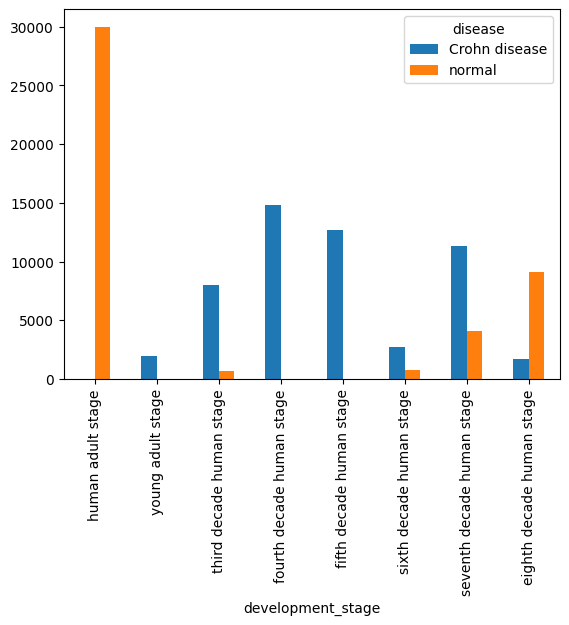

In [4]:
base_df.groupby(["development_stage", "disease"]).size().reset_index().pivot(index = "development_stage", columns = "disease", values = 0).plot(kind = "bar", stacked = False)

In [5]:
base_df.disease.value_counts().reset_index()

disease  count
0  Crohn disease  53224
1         normal  44564

/tmp/ipykernel_25043/2725217088.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  base_df.groupby([param1, "disease"]).size().reset_index().pivot(index = param1, columns = "disease", values = 0).plot(kind = "bar", stacked = False)


<Axes: xlabel='tissue'>

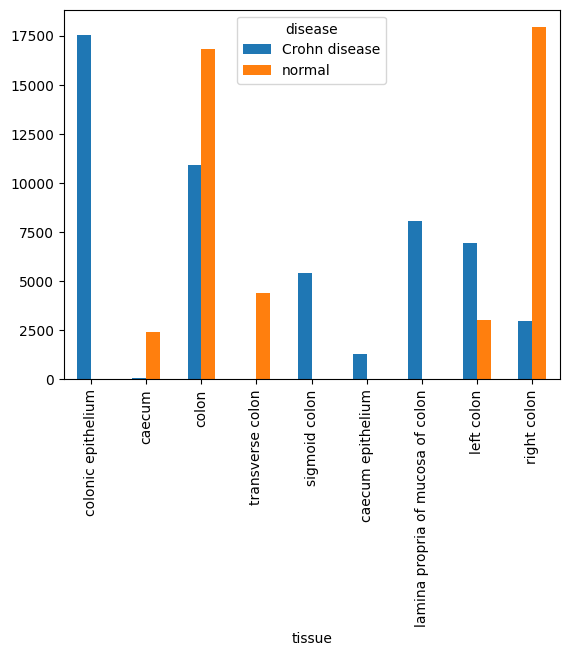

In [6]:
param1 = "tissue"
base_df.groupby([param1, "disease"]).size().reset_index().pivot(index = param1, columns = "disease", values = 0).plot(kind = "bar", stacked = False)

/tmp/ipykernel_25043/2114867355.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  base_df.groupby([param1, "disease"]).size().reset_index().pivot(index = param1, columns = "disease", values = 0).plot(kind = "bar", stacked = False)


<Axes: xlabel='cell_type'>

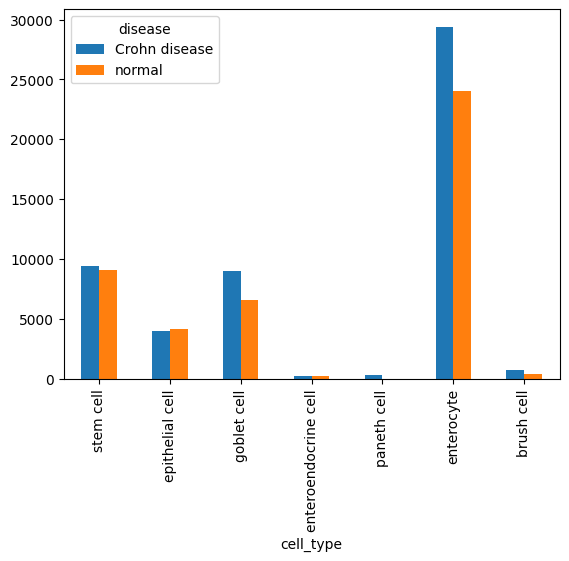

In [7]:
param1 = "cell_type"
base_df.groupby([param1, "disease"]).size().reset_index().pivot(index = param1, columns = "disease", values = 0).plot(kind = "bar", stacked = False)

/tmp/ipykernel_25043/4133589635.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  base_df.query("tissue == 'colon'").groupby([param1, "disease"]).size().reset_index().pivot(index = param1, columns = "disease", values = 0).plot(kind = "bar", stacked = False)


<Axes: xlabel='cell_type'>

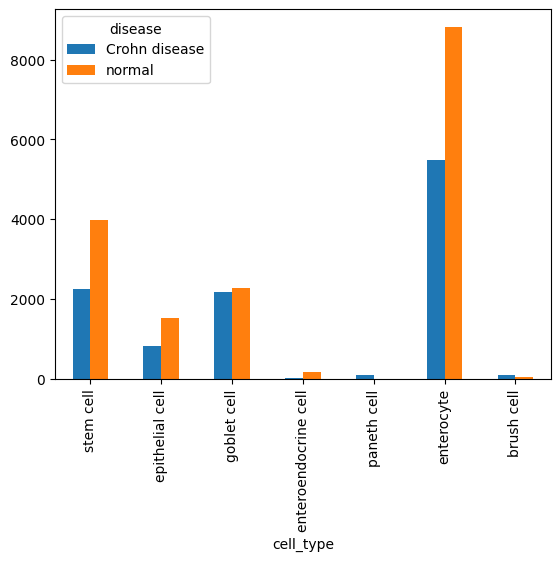

In [8]:
# only in tissue == colon:
param1 = "cell_type"
base_df.query("tissue == 'colon'").groupby([param1, "disease"]).size().reset_index().pivot(index = param1, columns = "disease", values = 0).plot(kind = "bar", stacked = False)

/tmp/ipykernel_25043/3359140649.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  base_df.groupby([param1, "disease"]).size().reset_index().pivot(index = param1, columns = "disease", values = 0).plot(kind = "bar", stacked = False)


<Axes: xlabel='sex'>

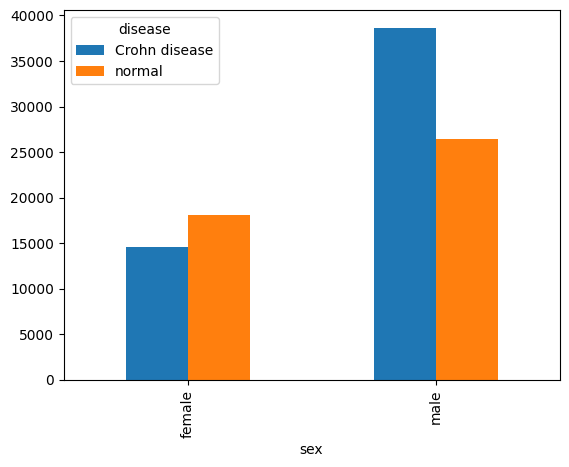

In [9]:
param1 = "sex"
base_df.groupby([param1, "disease"]).size().reset_index().pivot(index = param1, columns = "disease", values = 0).plot(kind = "bar", stacked = False)

In [10]:
import xgboost
from sklearn.model_selection import cross_val_score

tissues = base_df.tissue.unique().astype(str).tolist()

# for each tissue create a datasets and sample the data to have equal number of the 'disease types':
for tissue in tissues:
    print(f"---------\nAnalyzing tissue: {tissue}")
    df = base_df.reset_index().query(f"tissue == '{tissue}'").copy()
    minority_min = df.disease.value_counts().min()
    if 0 in df.disease.value_counts().values or minority_min < 1000:
        print("Skipping tissue, not enough data")
        continue
    else:
        print("Down sample tehe majority class")
        majority_class = df.disease.value_counts().idxmax()
        minority_class = df.disease.value_counts().idxmin()
        
        print(minority_min)
        print(f"Majority class: {majority_class}")
        df = pd.concat(
            [
                df.query(f"disease == '{minority_class}'"),
                df.query(f"disease == '{majority_class}'").sample(
                   minority_min, random_state=0
                ),
            ]
        )
        display(df.disease.value_counts().reset_index())
        indexes = df.index
        x = base_embeddings[indexes]
        y = pd.Categorical(base_df.disease).codes[indexes]
        print(x.shape, y.shape)
        scores = cross_val_score(xgboost.XGBClassifier(), x, y, cv=5, scoring="accuracy", n_jobs=-1)
        print(f"Accuracy ({tissue}): {scores.mean():.2f} (+/- {scores.std() * 2:.2f})")


---------
Analyzing tissue: lamina propria of mucosa of colon
Skipping tissue, not enough data
---------
Analyzing tissue: colonic epithelium
Skipping tissue, not enough data
---------
Analyzing tissue: colon
Down sample tehe majority class
10929
Majority class: normal


disease  count
0  Crohn disease  10929
1         normal  10929

(21858, 512) (21858,)
Accuracy (colon): 0.91 (+/- 0.05)
---------
Analyzing tissue: sigmoid colon
Skipping tissue, not enough data
---------
Analyzing tissue: right colon
Down sample tehe majority class
2945
Majority class: normal


disease  count
0  Crohn disease   2945
1         normal   2945

(5890, 512) (5890,)
Accuracy (right colon): 0.90 (+/- 0.08)
---------
Analyzing tissue: transverse colon
Skipping tissue, not enough data
---------
Analyzing tissue: left colon
Down sample tehe majority class
2991
Majority class: Crohn disease


disease  count
0  Crohn disease   2991
1         normal   2991

(5982, 512) (5982,)


In [ ]:
scores

array([0.9807853 , 0.98245614, 0.95317726, 0.97826087, 0.9180602 ])

In [ ]:
import joblib
model_fname = "colon_crohn_model_xgboost.joblib"
try:
    colon_crohn_model = joblib.load(model_fname)
except:
    tissue = "colon"
    colon_crohn_model = xgboost.XGBClassifier()
    df = base_df.reset_index().query(f"tissue == 'colon'").copy()
    minority_min = df.disease.value_counts().min()
    majority_class = df.disease.value_counts().idxmax()
    minority_class = df.disease.value_counts().idxmin()
    df = pd.concat(
        [ df.query(f"disease == '{minority_class}'"),
            df.query(f"disease == '{majority_class}'").sample(minority_min, random_state=0)
        ]
    )
    indexes = df.index
    x = base_embeddings[indexes]
    y = pd.Categorical(base_df.disease).codes[indexes]
    colon_crohn_model.fit(x, y)
    joblib.dump(colon_crohn_model, model_fname)

print(colon_crohn_model)
    

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)


In [ ]:
# umap on the colon cells alone
try:
    colon_umap_df = pd.read_parquet("colon_umap.parquet")
except:
    colon_index = base_df.reset_index().query("tissue == 'colon'").index
    colon_embeddings = base_embeddings[colon_index]
    colon_umap = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine').fit_transform(colon_embeddings)
    colon_umap_df = pd.DataFrame(colon_umap, columns=["umap_x", "umap_y"])
    colon_umap_df.to_parquet("colon_umap.parquet")
colon_umap_df["cell_type"] = base_df.reset_index().query("tissue == 'colon'")["cell_type"].values
colon_umap_df["disease"] = base_df.reset_index().query("tissue == 'colon'")["disease"].values

In [ ]:
melted = colon_umap_df.melt(["umap_x", "umap_y"], var_name="category", value_name="value")
melted

umap_x    umap_y   category          value
0      4.714729 -1.471495  cell_type     enterocyte
1      4.517813 -1.654043  cell_type     enterocyte
2      5.326974 -2.184189  cell_type     enterocyte
3      2.591550 -0.577702  cell_type     enterocyte
4      2.076234 -0.433830  cell_type    goblet cell
...         ...       ...        ...            ...
55511  2.132361  2.192084    disease  Crohn disease
55512  1.825527  2.304337    disease  Crohn disease
55513 -2.309162  4.799681    disease  Crohn disease
55514 -2.159060  3.508593    disease  Crohn disease
55515 -1.515241  5.256886    disease  Crohn disease

[55516 rows x 4 columns]

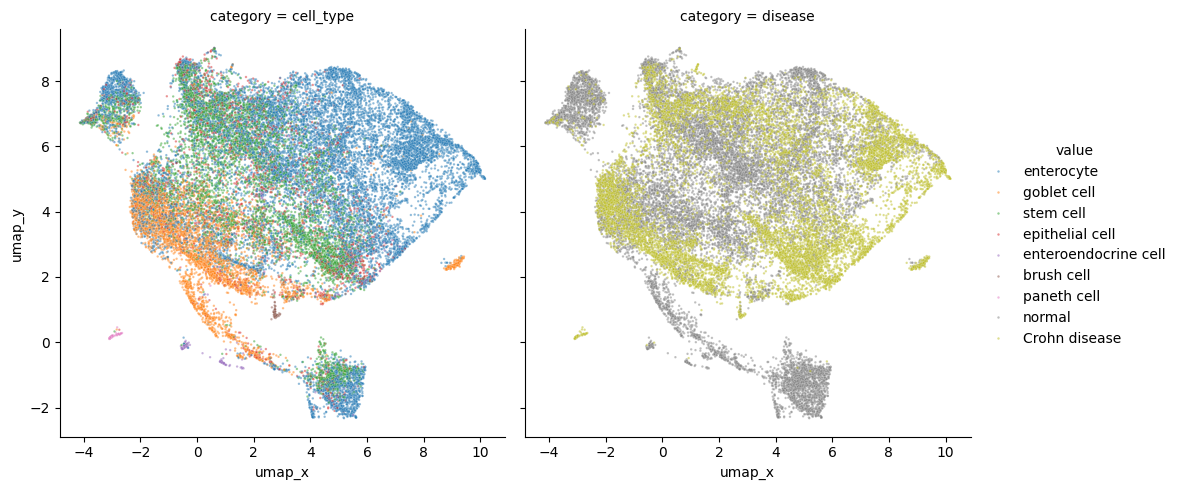

In [ ]:
sns.relplot(data=melted, x="umap_x", y="umap_y", hue="value", col="category", s=3, alpha=0.5)

In [ ]:
try:
    perturbation_df = pd.read_parquet("perturbation_df_colon_5.parquet")
except FileNotFoundError:
    base_df["disease_proba"] = colon_crohn_model.predict_proba(base_embeddings)[:, 0]
    naming = {0: "KO", 5.0 : "OE"}
    dfs = []
    genes_bar = tqdm(genes, desc="Calculating perturbation effect")
    for gene in genes_bar:
        for level in [0, 5.0]:
            genes_bar.set_description(f"Calculating perturbation effect for {gene} at {level}")
            df = base_df.copy().assign(gene = gene, level=naming[level])
            filename = file_pattern.format(gene = gene, level = level) + ".embeddings.npz"
            emb = np.load(filename)["emb"]
            df["proba_perturbed"] = colon_crohn_model.predict_proba(emb)[:,0]
            df = df.query("tissue == 'colon'") # !!!!!
            dfs.append(df)
    perturbation_df = pd.concat(dfs)
    perturbation_df.sample(10, random_state=42)
    perturbation_df["proba_disease_after_pertrubation"] = perturbation_df["proba_perturbed"] - perturbation_df["disease_proba"]
    perturbation_df.to_parquet("perturbation_df_colon_5.parquet")

perturbation_df["delta"] = perturbation_df["proba_disease_after_pertrubation"].abs()
print(perturbation_df.shape)
perturbation_df.sample(4, random_state=10)


(721708, 11)


tissue   cell_type   sex  \
cell_id                                                
H197396_N1-TATTACCCACCTCGTT  colon  enterocyte  male   
H197396_N3-ACGGGCTTCGCCTGTT  colon  enterocyte  male   
H197396_N1-GGCAATTGTTCCACTC  colon  enterocyte  male   
H197396_N1-CTAGTGAGTCCTCCAT  colon  enterocyte  male   

                                     development_stage disease  disease_proba  \
cell_id                                                                         
H197396_N1-TATTACCCACCTCGTT  eighth decade human stage  normal       0.000149   
H197396_N3-ACGGGCTTCGCCTGTT  eighth decade human stage  normal       0.000021   
H197396_N1-GGCAATTGTTCCACTC  eighth decade human stage  normal       0.000187   
H197396_N1-CTAGTGAGTCCTCCAT  eighth decade human stage  normal       0.032197   

                              gene level  proba_perturbed  \
cell_id                                                     
H197396_N1-TATTACCCACCTCGTT    CA2    KO         0.000053   
H197396_N3-ACGGGCTTCGCCTGTT  GAPDH    OE         0.000016   
H197396_N1-GGCAATTGTTCCACTC   MT1G    KO         0.011058   
H197396_N1-CTAGTGAGTCCTCCAT    TBP    OE         0.166108   

                             proba_disease_after_pertrubation     delta  
cell_id                                                                  
H197396_N1-TATTACCCACCTCGTT                         -0.000095  0.000095  
H197396_N3-ACGGGCTTCGCCTGTT                         -0.000005  0.000005  
H197396_N1-GGCAATTGTTCCACTC                          0.010872  0.010872  
H197396_N1-CTAGTGAGTCCTCCAT                          0.133911  0.133911

In [ ]:
base_df.query("tissue == 'colon'").cell_type.value_counts().reset_index()

cell_type  count
0            enterocyte  14288
1             stem cell   6223
2           goblet cell   4479
3       epithelial cell   2331
4  enteroendocrine cell    189
5            brush cell    147
6           paneth cell    101

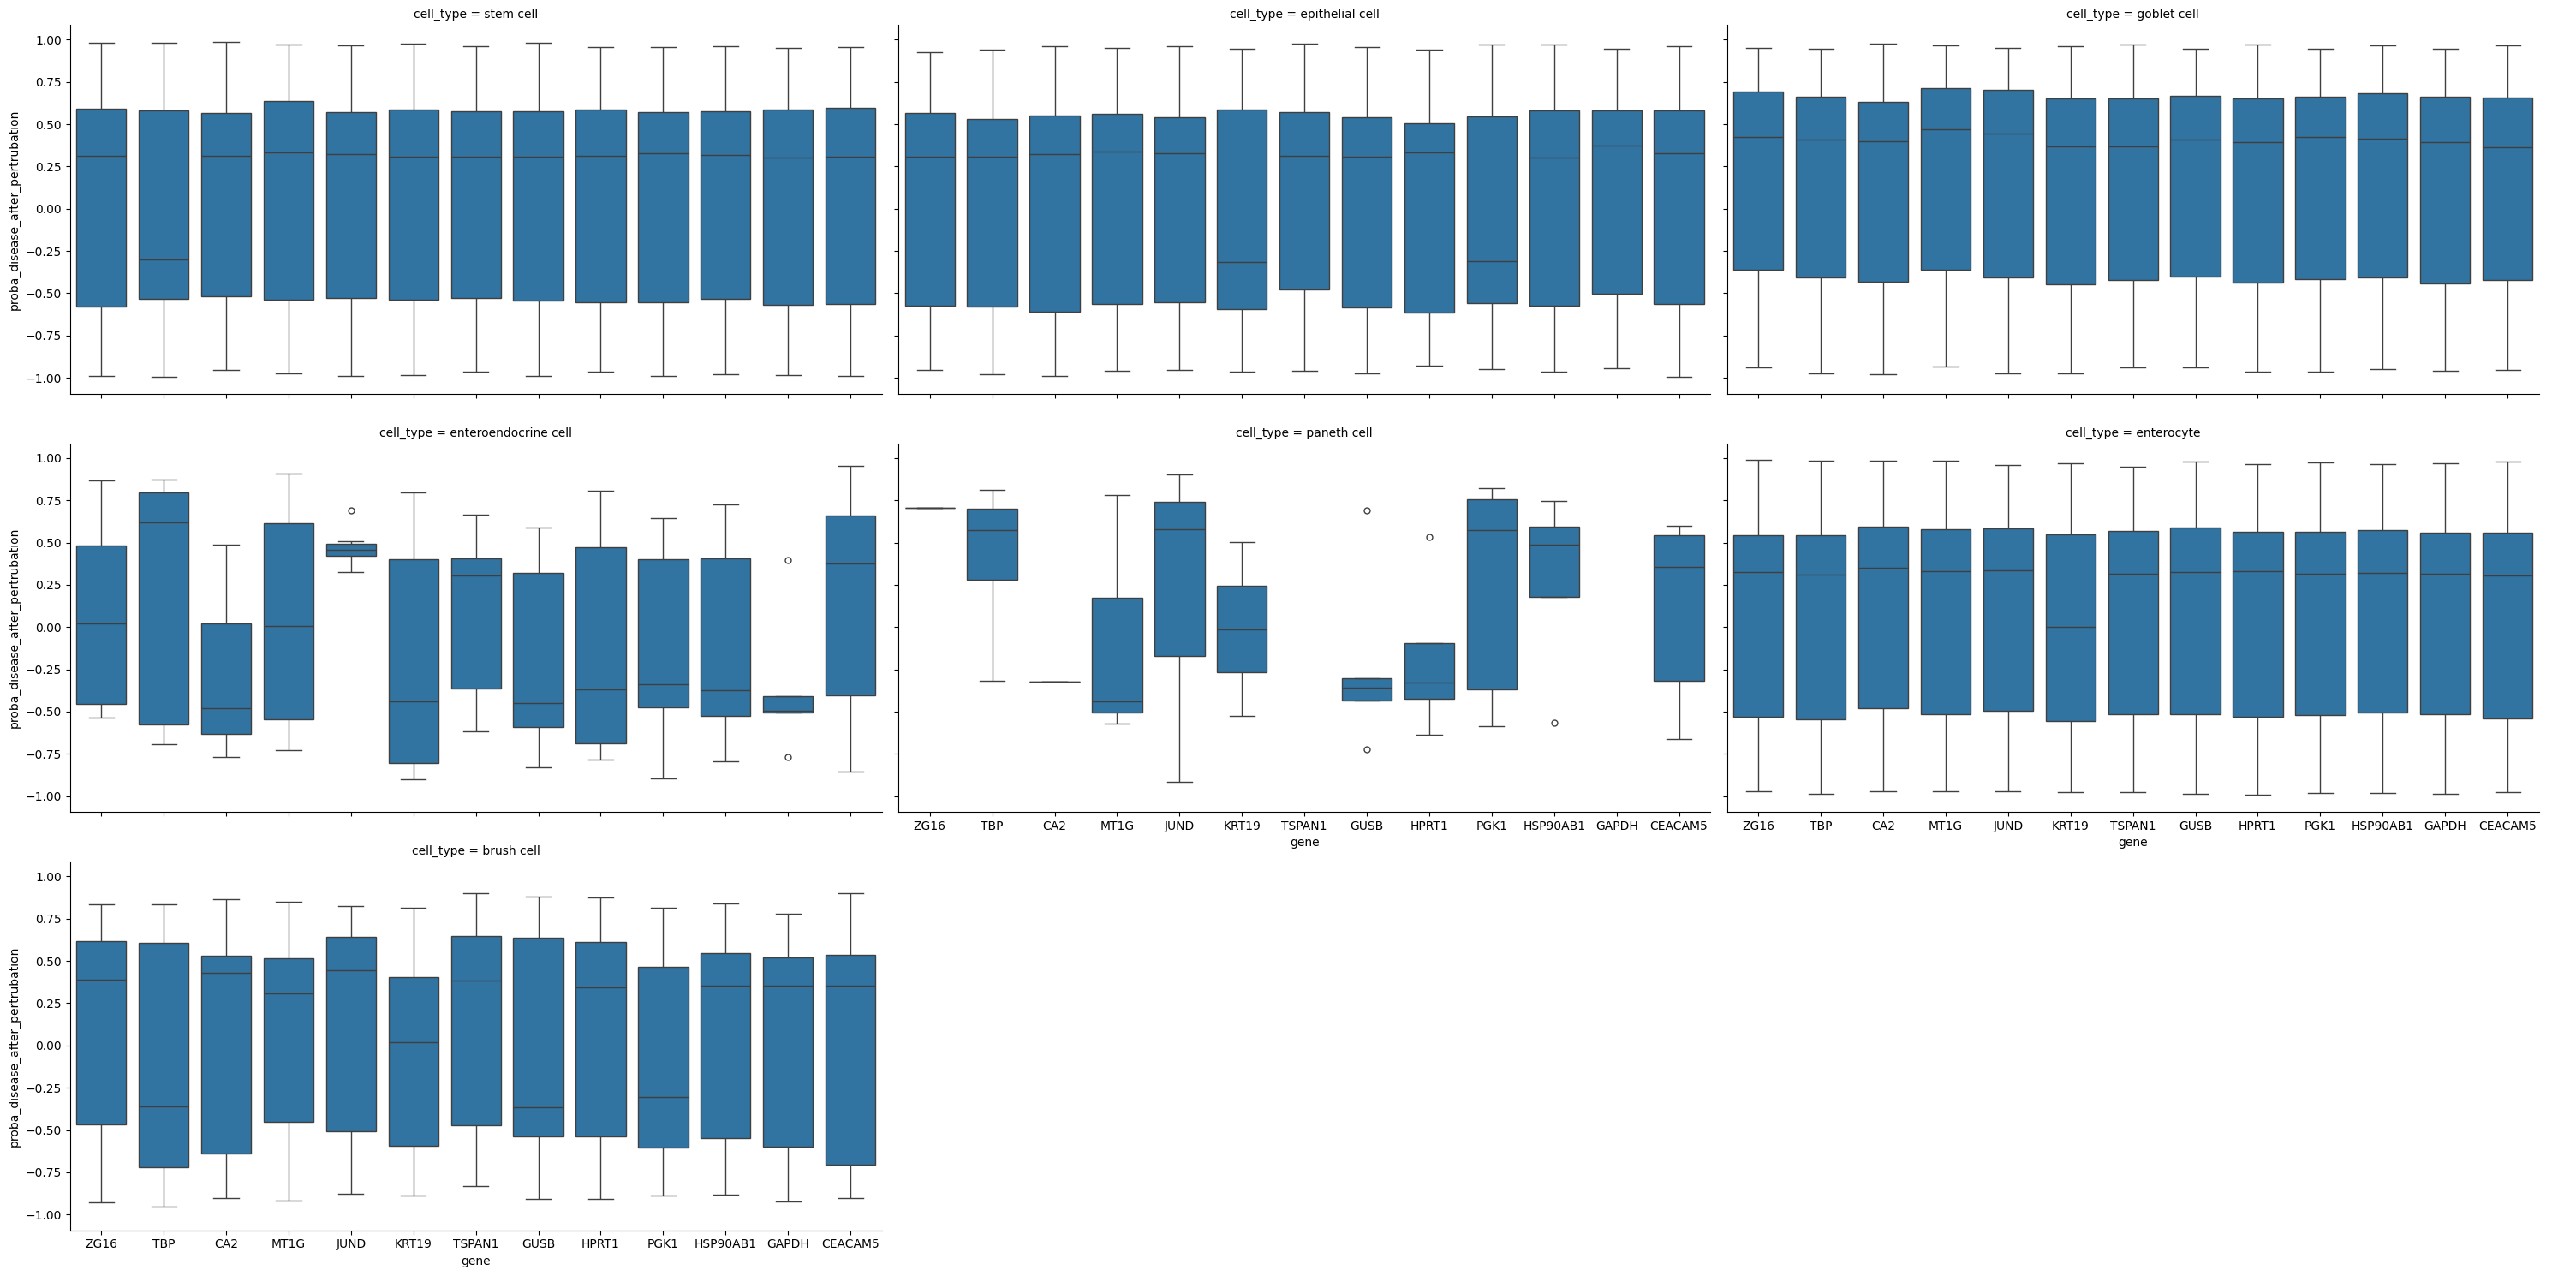

In [ ]:

df = perturbation_df.query("level == 'KO'").query("abs(proba_disease_after_pertrubation) > 0.3")
sns.catplot(data = df, x="gene", y="proba_disease_after_pertrubation", col="cell_type", col_wrap=3, kind="box", aspect=2)

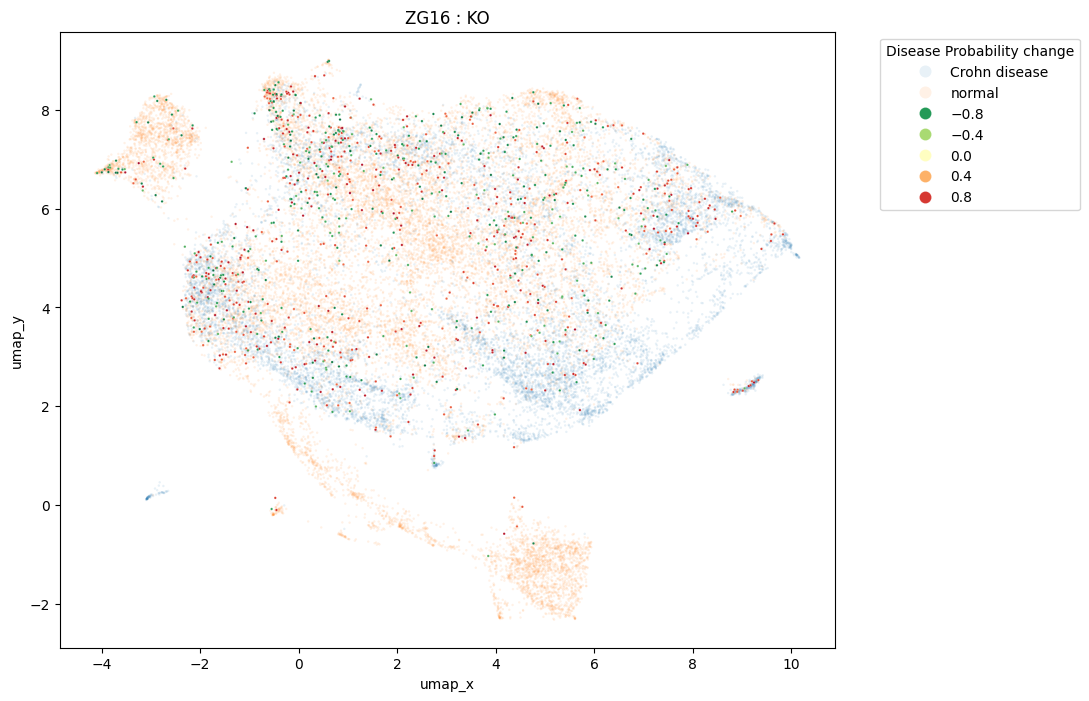

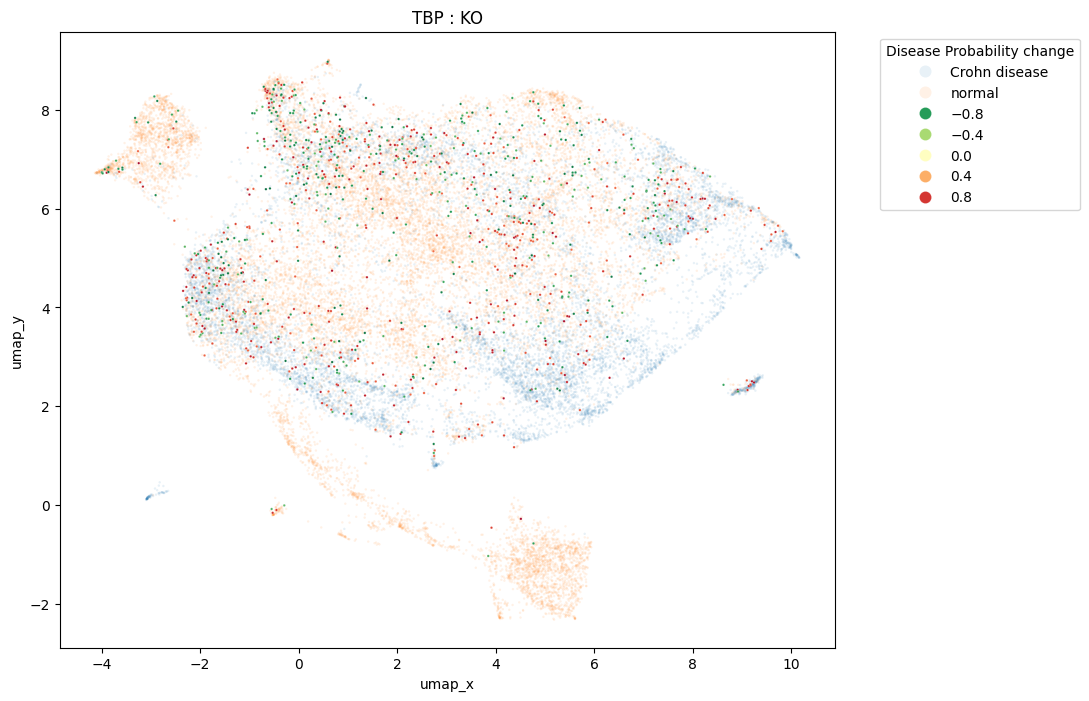

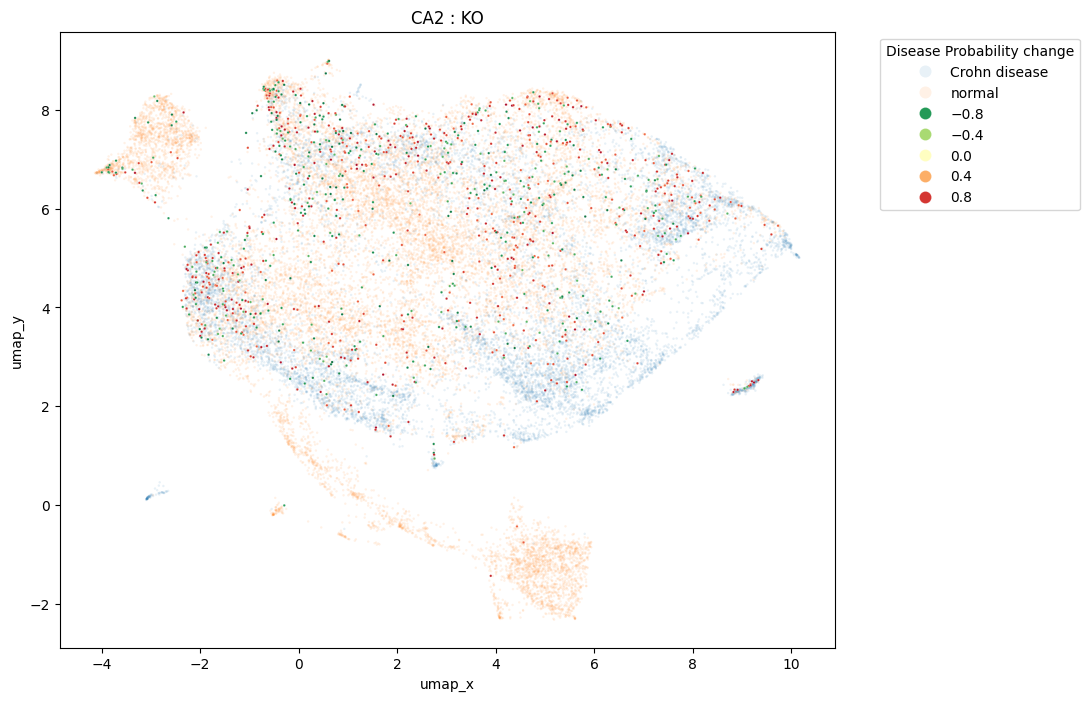

In [ ]:
level = "KO"
for gene in perturbation_df.gene.unique()[0:3]:
    # Filter the perturbation data for the current gene and level
    df = perturbation_df.query(f"gene == '{gene}'").query(f"level == '{level}'").copy()
    
    # Add UMAP coordinates
    df["umap_x"] = colon_umap_df["umap_x"].values
    df["umap_y"] = colon_umap_df["umap_y"].values
    df["size"] = 1

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # First scatter plot: all gray points
    sns.scatterplot(data=df, x="umap_x", y="umap_y", s=3, alpha=0.1, hue="disease", ax=ax)

    # Filter based on the threshold
    filtered = df.query("abs(proba_disease_after_pertrubation) > 0.6")
    
    # Second scatter plot: red-to-green color map
    scatter = sns.scatterplot(
        data=filtered, x="umap_x", y="umap_y",
        hue="proba_disease_after_pertrubation",
        palette=sns.color_palette("RdYlGn_r", as_cmap=True),
        s=3, alpha=0.95, ax=ax
    )

    # Add a color bar for the second scatter plot
    # cbar = plt.colorbar(scatter.collections[1], ax=ax)
    # cbar.set_label('Probability of Disease After Perturbation')

    # Set the plot title
    plt.title(f"{gene} : {level}")

    # Move the legend outside the plot - show 10 items
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', markerscale=5, title="Disease Probability change")
    
    # Show the plot
    plt.show()


In [ ]:
# umap that seperates by disease:

try:
    colon_umap_by_disease_df = pd.read_parquet("colon_umap_by_disease.parquet")
except:
    colon_index = base_df.reset_index().query("tissue == 'colon'").index
    colon_embeddings = base_embeddings[colon_index]
    y = pd.Categorical(base_df.reset_index().query("tissue == 'colon'")["disease"]).codes
    colon_umap = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine').fit_transform(colon_embeddings, y=y)
    colon_umap_by_disease_df = pd.DataFrame(colon_umap, columns=["umap_x", "umap_y"])
    colon_umap_by_disease_df["cell_type"] = base_df.reset_index().query("tissue == 'colon'")["cell_type"].values
    colon_umap_by_disease_df["disease"] = base_df.reset_index().query("tissue == 'colon'")["disease"].values
    colon_umap_by_disease_df.to_parquet("colon_umap_by_disease.parquet")
colon_umap_by_disease_df

umap_x     umap_y    cell_type        disease
0      -5.211131   0.072805   enterocyte         normal
1      -5.316149  -0.113718   enterocyte         normal
2      -4.470247  -0.633453   enterocyte         normal
3      -6.609862   1.521510   enterocyte         normal
4      -6.856825   1.850384  goblet cell         normal
...          ...        ...          ...            ...
27753  15.411726   8.891810   enterocyte  Crohn disease
27754  15.378996   8.998070   enterocyte  Crohn disease
27755  11.941646  10.129778   enterocyte  Crohn disease
27756  12.547686  10.360956  goblet cell  Crohn disease
27757  12.082406   9.711671  goblet cell  Crohn disease

[27758 rows x 4 columns]

<Axes: xlabel='umap_x', ylabel='umap_y'>

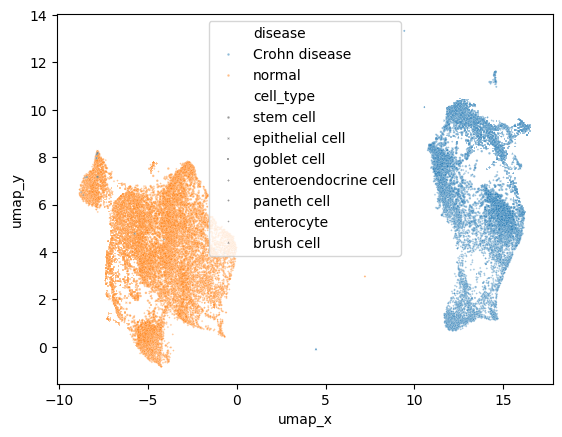

In [ ]:
sns.scatterplot(data=colon_umap_by_disease_df, x="umap_x", y="umap_y", hue="disease", style="cell_type", s=3, alpha=0.5)

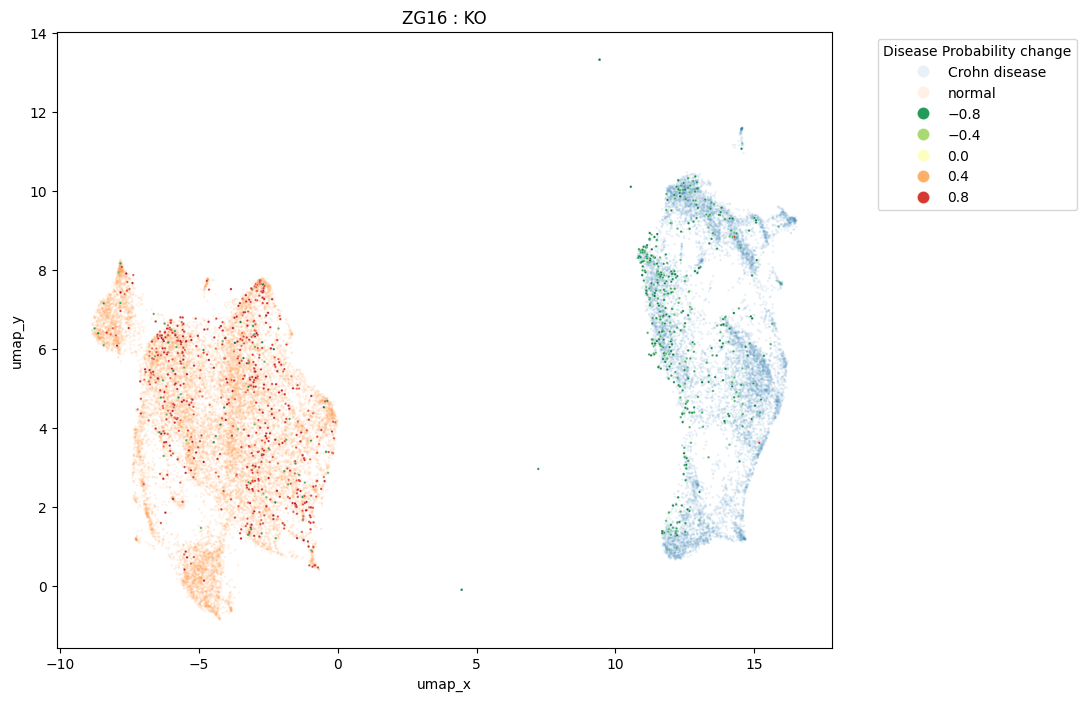

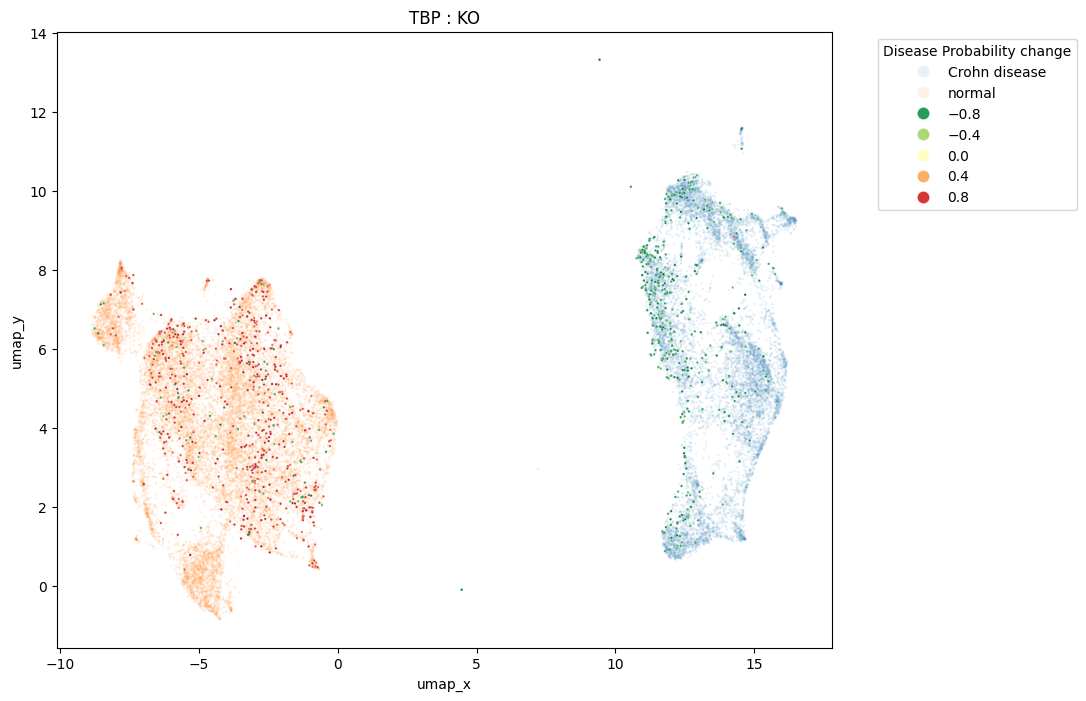

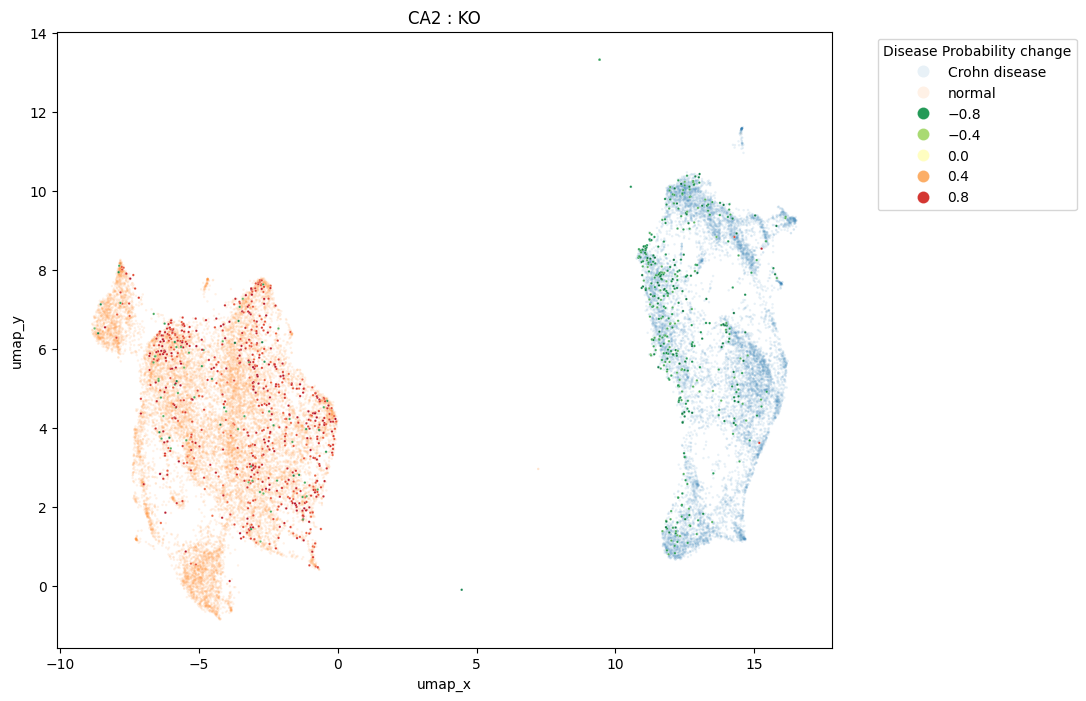

In [ ]:
level = "KO"
for gene in perturbation_df.gene.unique()[0:3]:
    # Filter the perturbation data for the current gene and level
    df = perturbation_df.query(f"gene == '{gene}'").query(f"level == '{level}'").copy()
    
    # Add UMAP coordinates
    df["umap_x"] = colon_umap_by_disease_df["umap_x"].values
    df["umap_y"] = colon_umap_by_disease_df["umap_y"].values
    df["size"] = 1

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # First scatter plot: all gray points
    sns.scatterplot(data=df, x="umap_x", y="umap_y", s=3, alpha=0.1, hue="disease", ax=ax)

    # Filter based on the threshold
    filtered = df.query("abs(proba_disease_after_pertrubation) > 0.6")
    
    # Second scatter plot: red-to-green color map
    scatter = sns.scatterplot(
        data=filtered, x="umap_x", y="umap_y",
        hue="proba_disease_after_pertrubation",
        palette=sns.color_palette("RdYlGn_r", as_cmap=True),
        s=3, alpha=0.95, ax=ax
    )

    # Add a color bar for the second scatter plot
    # cbar = plt.colorbar(scatter.collections[1], ax=ax)
    # cbar.set_label('Probability of Disease After Perturbation')

    # Set the plot title
    plt.title(f"{gene} : {level}")

    # Move the legend outside the plot - show 10 items
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', markerscale=5, title="Disease Probability change")
    
    # Show the plot
    plt.show()

In [ ]:

try:
    colon_umap_by_cell_type_df = pd.read_parquet("colon_umap_by_cell_type_df.parquet")
except:
    colon_index = base_df.reset_index().query("tissue == 'colon'").index
    colon_embeddings = base_embeddings[colon_index]
    y = pd.Categorical(base_df.reset_index().query("tissue == 'colon'")["cell_type"]).codes
    colon_umap = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine').fit_transform(colon_embeddings, y=y)
    colon_umap_by_cell_type_df = pd.DataFrame(colon_umap, columns=["umap_x", "umap_y"])
    colon_umap_by_cell_type_df["cell_type"] = base_df.reset_index().query("tissue == 'colon'")["cell_type"].values
    colon_umap_by_cell_type_df["disease"] = base_df.reset_index().query("tissue == 'colon'")["disease"].values
    colon_umap_by_cell_type_df.to_parquet("colon_umap_by_cell_type_df.parquet")
colon_umap_by_cell_type_df

umap_x     umap_y    cell_type        disease
0     -0.905749  -8.946148   enterocyte         normal
1     -0.966766  -9.139598   enterocyte         normal
2     -0.557328  -8.671472   enterocyte         normal
3     -0.574409  -9.521350   enterocyte         normal
4      6.974663   9.483094  goblet cell         normal
...         ...        ...          ...            ...
27753 -3.259895  -4.967586   enterocyte  Crohn disease
27754 -3.200300  -4.986245   enterocyte  Crohn disease
27755 -2.698774  -3.202507   enterocyte  Crohn disease
27756  3.720130  11.380308  goblet cell  Crohn disease
27757  3.474808  11.465274  goblet cell  Crohn disease

[27758 rows x 4 columns]

<Axes: xlabel='umap_x', ylabel='umap_y'>

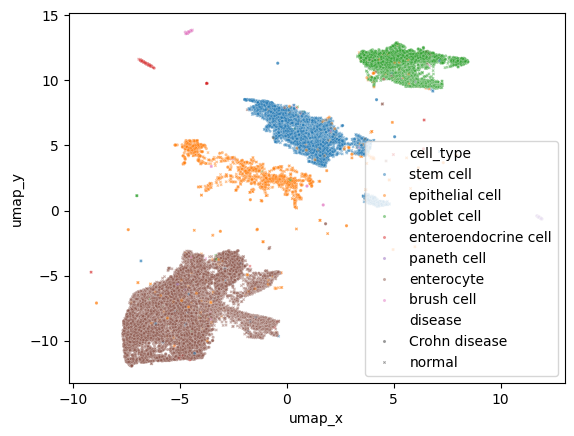

In [ ]:
sns.scatterplot(data=colon_umap_by_cell_type_df, x="umap_x", y="umap_y", hue="cell_type", style="disease", s=5, alpha=0.5)

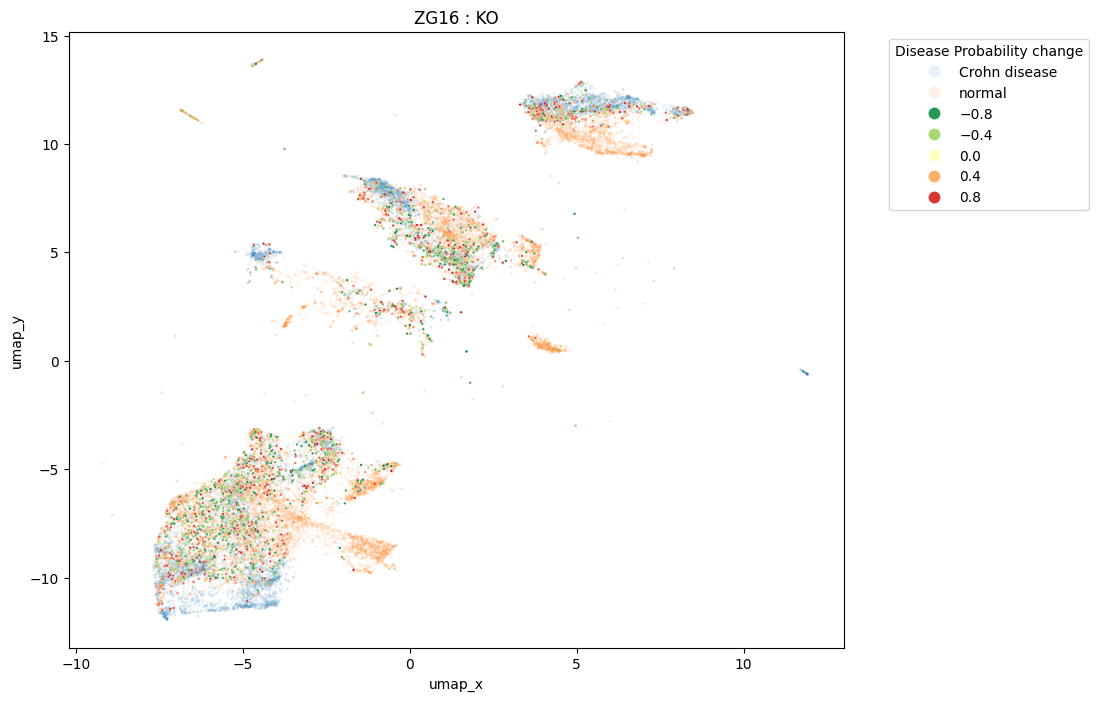

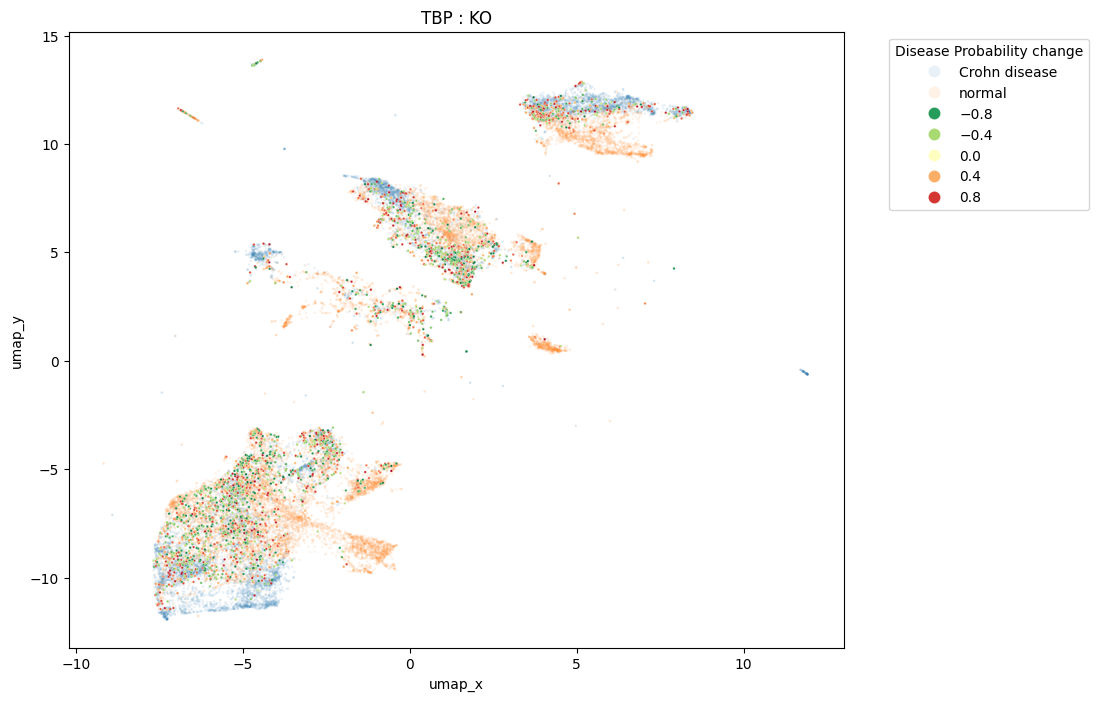

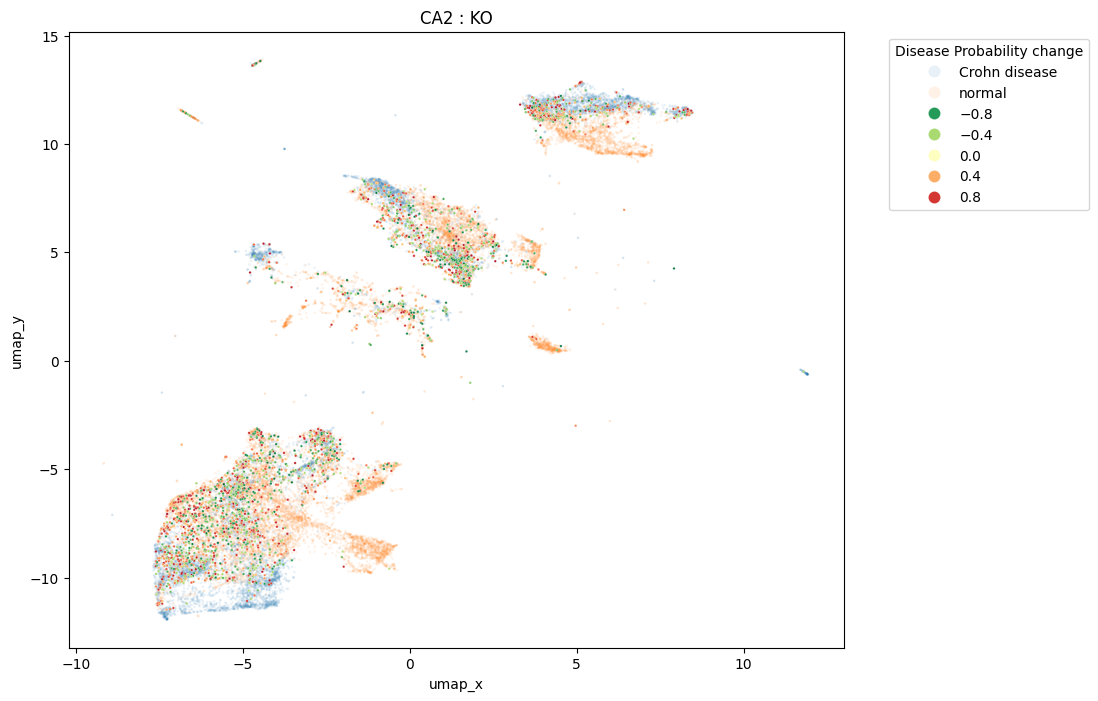

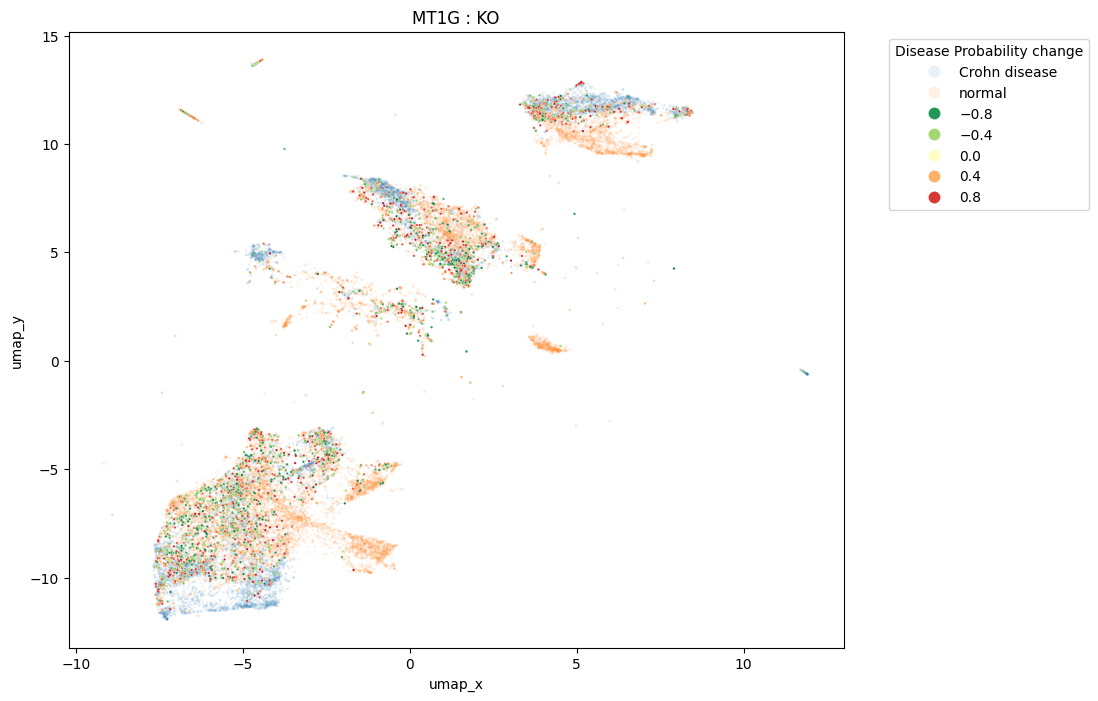

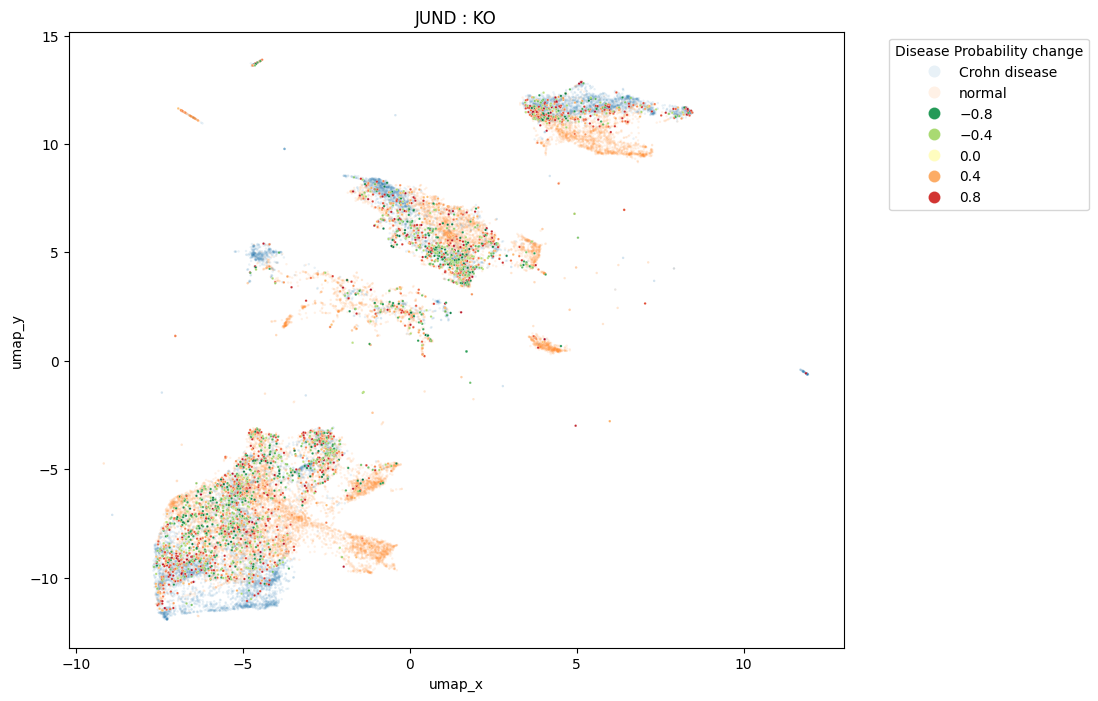

In [ ]:
level = "KO"
for gene in perturbation_df.gene.unique()[0:5]:
    df = perturbation_df.query(f"gene == '{gene}'").query(f"level == '{level}'").copy()
    df["umap_x"] = colon_umap_by_cell_type_df["umap_x"].values
    df["umap_y"] = colon_umap_by_cell_type_df["umap_y"].values
    df["size"] = 1

    fig, ax = plt.subplots(figsize=(10, 8))

    sns.scatterplot(data=df, x="umap_x", y="umap_y", s=3, alpha=0.1, hue="disease", ax=ax)

    filtered = df.query("abs(proba_disease_after_pertrubation) > 0.3")
    
    scatter = sns.scatterplot(
        data=filtered, x="umap_x", y="umap_y",
        hue="proba_disease_after_pertrubation",
        palette=sns.color_palette("RdYlGn_r", as_cmap=True),
        s=3, alpha=0.95, ax=ax
    )

    plt.title(f"{gene} : {level}")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', markerscale=5, title="Disease Probability change")
    

In [1]:


# level = "KO"

# for gene in perturbation_df.gene.unique()[0:1]:
#     # Filter the data for the current gene and level
#     df = perturbation_df.query(f"gene == '{gene}'").query(f"level == '{level}'").copy()
#     df["umap_x"] = colon_umap_by_cell_type_df["umap_x"].values
#     df["umap_y"] = colon_umap_by_cell_type_df["umap_y"].values

#     fig = go.Figure()

#     fig.add_trace(go.Scatter(
#         x=df["umap_x"], y=df["umap_y"],
#         mode='markers',
#         marker=dict(size=3, color='gray', opacity=0.1),
#         name="Background"
#     ))

#     # Filter for significant perturbation changes
#     filtered = df.query("abs(proba_disease_after_pertrubation) > 0.3")
    
#     # Create the second scatter plot with the red-to-green colormap
#     fig2 = px.scatter(
#         filtered, x="umap_x", y="umap_y",
#         color="proba_disease_after_pertrubation",
#         color_continuous_scale="RdYlGn_r",  # Reversed red-to-green colormap
#         range_color=(-1, 1),
#         opacity=0.95,
#         title=f"{gene} : {level}",
#         size=3,
#     )
    
#     # Add the filtered points to the initial gray scatter plot
#     for trace in fig2.data:
#         fig.add_trace(trace)
    
#     # Update the layout to include a color bar title and a better legend positioning
#     fig.update_layout(
#         coloraxis_colorbar=dict(title="Disease Probability Change"),
#         legend=dict(x=1.05, y=1),
#         title=f"{gene} : {level}",
#         width=900, height=900
#     )

#     # Show the interactive plot
#     fig.show()
